In [158]:
# Import Libraries and Packages
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import substring, col
from statsmodels.formula.api import ols, glm
from pyspark.sql.functions import *

In [ ]:
# Create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 1") 
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true") 
    .config("spark.sql.session.timeZone", "Etc/UTC") 
    #.config("spark.driver.memory", "12g") ## only if needed
    .getOrCreate()
)

In [160]:
#Load in Data
df_acc = spark.read.parquet('../data/landing/accidents_landing')
df_taxis = spark.read.parquet('../data/landing/taxis_landing.parquet')

df_taxis.printSchema()

root
 |-- congestion_surcharge: double (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- taxi_colour: string (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- trip_distance: double (nullable = true)



In [161]:
df_acc.printSchema()

root
 |-- crash_date: string (nullable = true)
 |-- crash_time: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)
 |-- contributing_factor_vehicle1: string (nullable = true)
 |-- contributing_factor_vehicle2: string (nullable = true)
 |-- contributing_factor_vehicle3: string (nullable = true)
 |-- contributing_factor_vehicle4: string (nullable = true)
 |-- contributing_factor_vehicle5: string (nullable = true)
 |-- fatalities: long (nullable = true)
 |-- injuries: long (nullable = true)
 |-- total_harmed: long (nullable = true)
 |-- num_vehicles: long (nullable = true)



In [ ]:
# Datatype conversion
def convert_datatype(df, column_name, datatype):
    df = df.withColumn(
    column_name,
    F.col(column_name).cast(datatype)
)
    return(df)

# Convert Boolean column, congestion into int
df_taxis = convert_datatype(df_taxis, 'congestion_surcharge', 'int')

In [ ]:
df_taxis = df_taxis.withColumn('tpep_pickup_datetime', F.to_timestamp('tpep_pickup_datetime', 'yyyy-MM-dd HH:mm:ss'))\
       .withColumn('tpep_dropoff_datetime', F.to_timestamp('tpep_dropoff_datetime', 'yyyy-MM-dd HH:mm:ss'))

# Calculate Time difference in Seconds
df_taxis=df_taxis.withColumn('tpep_pickup_datetime', F.to_timestamp(col('tpep_pickup_datetime')))\
  .withColumn('duration_sec',col("tpep_dropoff_datetime").cast("long") - col('tpep_pickup_datetime').cast("long"))

df_taxis = df_taxis.withColumn('duration_min',round(col('duration_sec')/60))
df_taxis = df_taxis.drop('duration_sec')
df_taxis

congestion_surcharge,dolocationid,pulocationid,taxi_colour,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,duration_min
0,7,145,Y,2020-02-01 00:30:32,2020-02-01 00:17:35,2.6,13.0
2,61,45,Y,2020-02-01 01:05:36,2020-02-01 00:32:47,4.8,33.0
2,140,186,Y,2020-02-01 00:43:28,2020-02-01 00:31:44,3.2,12.0
2,140,144,Y,2020-02-01 00:31:39,2020-02-01 00:07:35,4.38,24.0
0,152,238,Y,2020-02-01 01:01:29,2020-02-01 00:51:43,2.28,10.0
2,107,249,Y,2020-02-01 00:20:48,2020-02-01 00:15:49,1.0,5.0
2,256,79,Y,2020-02-01 00:50:22,2020-02-01 00:25:31,3.4,25.0
2,68,224,Y,2020-02-01 00:24:29,2020-02-01 00:11:15,2.1,13.0
0,42,116,Y,2020-02-01 01:02:26,2020-02-01 00:58:26,0.8,4.0
2,45,161,Y,2020-02-01 00:48:10,2020-02-01 00:03:57,7.22,44.0


In [164]:
df_taxis = df_taxis.withColumn('speed_miles_per_min', round(col('trip_distance')/col('duration_min'),2))
df_taxis = df_taxis.withColumn("pu_date", F.to_date(F.col("tpep_pickup_datetime")))
df_taxis = df_taxis.withColumn("hour", F.date_part(F.lit("Hour"), F.col("tpep_pickup_datetime")))
df_taxis = df_taxis.withColumn("day", F.date_part(F.lit("DAYOFWEEK"), F.col("tpep_pickup_datetime"))) # Starting with sunday = 1
df_taxis = df_taxis.withColumn("week", F.date_part(F.lit("WEEK"), F.col("tpep_pickup_datetime")))
trips_per_week = df_taxis.groupBy('week').count().sort('week')
trips_per_hour = df_taxis.groupBy('hour').count().sort('hour')
trips_per_day = df_taxis.groupBy('day').count().sort('day')
df_taxis.show(1000)

+--------------------+------------+------------+-----------+---------------------+--------------------+-------------+------------+-------------------+----------+----+---+----+
|congestion_surcharge|dolocationid|pulocationid|taxi_colour|tpep_dropoff_datetime|tpep_pickup_datetime|trip_distance|duration_min|speed_miles_per_min|   pu_date|hour|day|week|
+--------------------+------------+------------+-----------+---------------------+--------------------+-------------+------------+-------------------+----------+----+---+----+
|                   0|           7|         145|          Y|  2020-02-01 00:30:32| 2020-02-01 00:17:35|          2.6|        13.0|                0.2|2020-02-01|   0|  7|   5|
|                   2|          61|          45|          Y|  2020-02-01 01:05:36| 2020-02-01 00:32:47|          4.8|        33.0|               0.15|2020-02-01|   0|  7|   5|
|                   2|         140|         186|          Y|  2020-02-01 00:43:28| 2020-02-01 00:31:44|          3.2|   

In [165]:
df_taxis.count()

102823604

In [166]:
# Extract day and hour from crash_date, extract time from crash_time
df_acc = df_acc.withColumn("hour", substring(F.col("crash_time"), 1, 2))
df_acc = df_acc.withColumn("month", substring(F.col("crash_date"), 6, 2))
df_acc = df_acc.withColumn("day", substring(F.col("crash_date"), 9, 2))

taxi_sums = df_taxis.groupby('week').sum('trip_distance', 'duration_min', 'congestion_surcharge')
taxi_sums = taxi_sums.sort('week')

In [167]:
df_acc

crash_date,crash_time,borough,zip_code,latitude,longitude,location,contributing_factor_vehicle1,contributing_factor_vehicle2,contributing_factor_vehicle3,contributing_factor_vehicle4,contributing_factor_vehicle5,fatalities,injuries,total_harmed,num_vehicles,hour,month,day
2020-03-21,18:20:00,QUEENS,11419.0,40.69571,-73.818825,POINT (-73.818825...,Driver Inattentio...,Unspecified,NULL,NULL,NULL,0,0,0,2,18,03,21
2020-03-21,10:45:00,BROOKLYN,11230.0,40.610786,-73.958664,POINT (-73.958664...,Unspecified,Unspecified,Unspecified,NULL,NULL,0,0,0,3,10,03,21
2020-03-21,11:00:00,BROOKLYN,11208.0,40.683693,-73.87964,POINT (-73.87964 ...,Unspecified,NULL,NULL,NULL,NULL,0,0,0,1,11,03,21
2020-03-21,02:07:00,MANHATTAN,10036.0,40.756565,-73.99028,POINT (-73.99028 ...,Passing Too Closely,Unspecified,NULL,NULL,NULL,0,0,0,2,02,03,21
2020-03-21,15:40:00,MANHATTAN,10021.0,40.771782,-73.96544,POINT (-73.96544 ...,Following Too Clo...,Following Too Clo...,NULL,NULL,NULL,0,0,0,2,15,03,21
2020-03-21,21:00:00,BRONX,10455.0,40.816307,-73.90806,POINT (-73.90806 ...,Driver Inattentio...,Driver Inattentio...,NULL,NULL,NULL,0,0,0,2,21,03,21
2020-03-21,01:00:00,NULL,NaN,40.827198,-73.93668,POINT (-73.93668 ...,Alcohol Involvement,Unspecified,Unspecified,Unspecified,NULL,0,2,2,4,01,03,21
2020-03-21,23:05:00,QUEENS,11378.0,40.72554,-73.90613,POINT (-73.90613 ...,Unspecified,Unspecified,Unspecified,NULL,NULL,0,0,0,3,23,03,21
2020-03-21,17:15:00,BROOKLYN,11207.0,40.683933,-73.91228,POINT (-73.91228 ...,Unspecified,Unspecified,NULL,NULL,NULL,0,0,0,2,17,03,21
2020-03-21,23:50:00,BROOKLYN,11207.0,40.66919,-73.8857,POINT (-73.8857 4...,Unspecified,NULL,NULL,NULL,NULL,0,0,0,1,23,03,21


In [168]:
pd_month = df_acc.groupBy('month').sum('total_harmed',  'num_vehicles')
pd_month = pd_month.sort('month')
pd_month = pd_month.toPandas()

In [169]:
monthly_ave = (pd_month['sum(total_harmed)'].mean())
monthly_ave = int(monthly_ave)
print("Average Number of Crashes Per Month", monthly_ave)


Average Number of Crashes Per Month 435


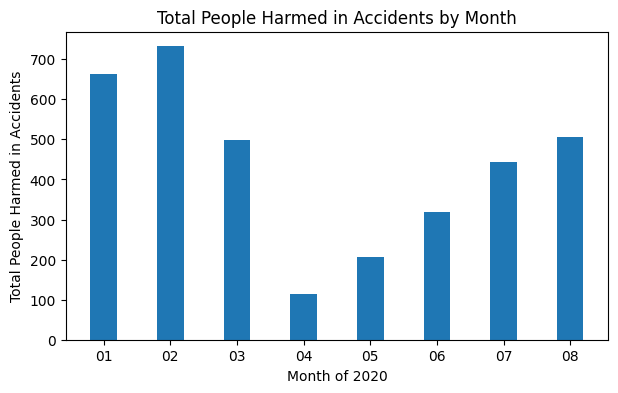

In [ ]:
fig = plt.figure(figsize = (7, 4))
# creating bar plot
plt.bar(pd_month['month'], pd_month['sum(total_harmed)'], width = 0.4)

plt.xlabel("Month of 2020")
plt.ylabel("Total People Harmed in Accidents")
plt.title("Total People Harmed in Accidents by Month")
plt.show()

In [171]:
weekly_acc = df_acc.groupBy(weekofyear('crash_date').alias('week')).agg(sum('fatalities'), sum('total_harmed'),\
                                                                        sum('injuries'), sum('num_vehicles')).sort('week')
weekly_taxis = df_taxis.groupBy(weekofyear('tpep_pickup_datetime').alias('week')).agg(mean('trip_distance'), 
                                            mean('duration_min'), mean('speed_miles_per_min'))
weekly_taxis = weekly_taxis.sort("week", ascending=[True]) 
df_week_summary = weekly_taxis.drop('week')
pd_week_summary = pd.concat([weekly_acc.toPandas(), df_week_summary.toPandas()], axis=1)

In [172]:
taxi_sums = taxi_sums.drop('week')
pd_week_summary = pd.concat([pd_week_summary, taxi_sums.toPandas()], axis=1)
pd_week_summary = pd_week_summary[0:34] # Accident data frame is over a shorter time period, first 34 weeks only

In [173]:
pd_week_summary.rename(columns={'sum(fatalities)': 'fatalities', 'sum(injuries)': 'injuries', 
                                'sum(num_vehicles)': 'crashed_vehicles', 'avg(trip_distance)': 'ave_miles',
                                'avg(duration_min)': 'ave_duration_minutes', 'avg(speed_miles_per_min)': 'ave_miles_per_min',
                                'sum(trip_distance)': 'total_miles', 'sum(duration_min)': 'total_time_minutes', 
                                'sum(congestion_surcharge)': 'total_congestion', 'sum(total_harmed)':'total_harmed'}, inplace=True)

In [174]:
# Log transform to produce comparable scales
pd_week_summary['total_congestion'] = np.log(pd_week_summary['total_congestion'])
pd_week_summary['total_time_minutes'] = np.log(pd_week_summary['total_time_minutes'])
pd_week_summary['ave_miles_per_min'] = np.log(pd_week_summary['ave_miles_per_min']+0.1)
pd_week_summary['ave_duration_minutes'] = np.log(pd_week_summary['ave_duration_minutes'])
pd_week_summary['ave_miles'] = np.log(pd_week_summary['ave_miles'])

pd_week_summary


,week,fatalities,total_harmed,injuries,crashed_vehicles,ave_miles,ave_duration_minutes,ave_miles_per_min,total_miles,total_time_minutes,total_congestion
0,1.0,2.0,122.0,120.0,286.0,1.178644,2.784955,-1.124384,1.186364e+07,17.895300,15.636701
1,2.0,0.0,152.0,152.0,470.0,1.099360,2.782488,-1.202795,1.854646e+07,18.418917,16.175486
2,3.0,0.0,156.0,156.0,500.0,1.055828,2.790763,-1.221218,1.787564e+07,18.433885,16.208058
3,4.0,0.0,142.0,142.0,462.0,1.059937,2.778856,-1.215837,1.771888e+07,18.409061,16.196815
4,5.0,0.0,124.0,124.0,515.0,1.095093,2.774743,-1.215762,1.892325e+07,18.435552,16.227440
5,6.0,0.0,188.0,188.0,527.0,1.052332,2.794976,-1.237273,1.839261e+07,18.470104,16.242676
6,7.0,0.0,198.0,198.0,564.0,1.044806,2.813874,-1.251625,1.828520e+07,18.490670,16.242157
7,8.0,0.0,172.0,172.0,492.0,1.136137,2.786647,-1.180351,1.844623e+07,18.380881,16.157236
8,9.0,0.0,160.0,160.0,587.0,1.169875,2.802430,-1.194350,2.115433e+07,18.499910,16.257326
9,10.0,0.0,214.0,214.0,589.0,1.212177,2.813227,-1.172637,2.116762e+07,18.469033,16.215387


In [175]:
x_cols = ['total_harmed', 'crashed_vehicles', 'total_miles', 'ave_duration_minutes',
       'total_time_minutes', 'total_congestion', 'ave_miles_per_min', 'ave_miles']

# standardize (by calculating the zscore) so our data has mean 0 and var 1
from scipy.stats import zscore

pd_standard = pd_week_summary[x_cols].astype(float).apply(zscore)
pd_standard

pd_transformed = pd.concat([pd_standard, pd_week_summary['week']], axis=1)
pd_transformed

# Unsuitable for normalisation
remaining = ['ave_miles', 'ave_duration_minutes']

In [176]:
from pyspark.sql.functions import mean

sdf_transformed = spark.createDataFrame(pd_transformed)

#calculate mean
ave = pd_transformed['ave_miles_per_min'].mean()

sdf_transformed = sdf_transformed.withColumn('ave_miles_per_min', when(sdf_transformed['ave_miles_per_min']>3, 0).otherwise(sdf_transformed['ave_miles_per_min']))
sdf_transformed = sdf_transformed.withColumn('ave_miles', when(abs(sdf_transformed['ave_miles'])>3, 0).otherwise(sdf_transformed['ave_miles']))
sdf_transformed = sdf_transformed.withColumn('ave_duration_minutes', when(abs(sdf_transformed['ave_duration_minutes'])>3, 0).otherwise(sdf_transformed['ave_miles_per_min']))
# rename ave_miles_per_min to log

In [177]:
sdf_transformed

total_harmed,crashed_vehicles,total_miles,ave_duration_minutes,total_time_minutes,total_congestion,ave_miles_per_min,ave_miles,week
0.39558229946312756,0.2111463370830552,0.41035926303324194,-0.8002506025474986,1.0009453600623976,0.9877605940821234,-0.8002506025474986,-0.9914457204544836,1.0
0.9350127078219379,1.217953871222989,1.3953215087524813,-1.0007047694161781,1.395331730979828,1.3896381130773523,-1.0007047694161781,-1.129887224484555,2.0
1.0069367622697794,1.382107273528413,1.296451739640896,-1.0478037425398907,1.4066054464175923,1.4139334219608604,-1.0478037425398907,-1.205901153638457,3.0
0.7552025717023345,1.1741796306082093,1.2733475384190576,-1.034045911330858,1.3879082804426968,1.4055470854827208,-1.034045911330858,-1.1987269887743714,4.0
0.4315443266870483,1.4641839746811252,1.4508551154071037,-1.0338559268964886,1.4078611387016016,1.4283902593029165,-1.0338559268964886,-1.1373385360674089,5.0
1.5823291978525102,1.5298453356032948,1.3726453906309986,-1.088846133757988,1.4338851025081791,1.4397543109861308,-1.088846133757988,-1.2120059853431424,6.0
1.7621393339721139,1.732301198446651,1.3568158842948026,-1.1255364885458405,1.4493758903214535,1.4393675240767727,-1.1255364885458405,-1.2251471728366625,7.0
1.294632980061145,1.3383330329136334,1.3805490809177214,-0.9433282481818953,1.366682935303256,1.3760251882685484,-0.9433282481818953,-1.0656685017934677,8.0
1.0788608167176208,1.8581521402141428,1.7796886416464346,-0.9791158579692828,1.4563354815135308,1.4506817994437884,-0.9791158579692828,-1.0067562723821852,9.0
2.049835551763479,1.8690957003678377,1.7816463147381925,-0.9236072891917316,1.433078730230536,1.4193998399127432,-0.9236072891917316,-0.932890092750209,10.0


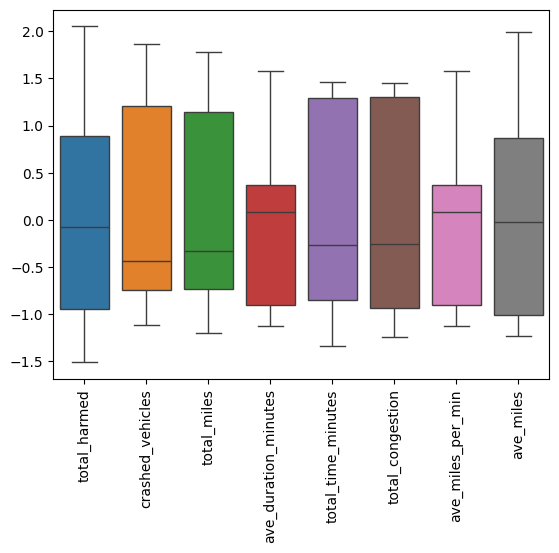

In [178]:
import seaborn as sns
ax = sns.boxplot(data=sdf_transformed[x_cols].toPandas())
ax.tick_params(axis='x', labelrotation=90) # ave_duration_minutes and ave_miles still skewed

In [ ]:
feb_crashes = df_acc[df_acc['month']=='02']
feb_crashes = feb_crashes.toPandas()

In [181]:
feb_crashes

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,contributing_factor_vehicle1,contributing_factor_vehicle2,contributing_factor_vehicle3,contributing_factor_vehicle4,contributing_factor_vehicle5,fatalities,injuries,total_harmed,num_vehicles,hour,month,day
0,2020-02-29,11:30:00,BROOKLYN,11208.0,40.688942,-73.874886,POINT (-73.874886 40.688942),Following Too Closely,Unspecified,None,None,None,0,0,0,2,11,02,29
1,2020-02-29,16:55:00,None,NaN,40.864113,-73.921260,POINT (-73.92126 40.864113),Driver Inattention/Distraction,Unspecified,None,None,None,0,0,0,2,16,02,29
2,2020-02-29,15:53:00,MANHATTAN,10031.0,40.832695,-73.949720,POINT (-73.94972 40.832695),Driver Inattention/Distraction,Driver Inattention/Distraction,None,None,None,0,0,0,2,15,02,29
3,2020-02-29,07:20:00,BROOKLYN,11226.0,40.647095,-73.958145,POINT (-73.958145 40.647095),Unspecified,None,None,None,None,0,0,0,1,07,02,29
4,2020-02-29,09:55:00,None,NaN,40.811830,-73.961120,POINT (-73.96112 40.81183),Traffic Control Disregarded,Unspecified,None,None,None,0,4,4,2,09,02,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,2020-02-01,22:20:00,BROOKLYN,11211.0,40.714066,-73.949380,POINT (-73.94938 40.714066),Turning Improperly,Unspecified,None,None,None,0,0,0,1,22,02,01
1135,2020-02-01,06:25:00,None,NaN,40.805140,-73.911415,POINT (-73.911415 40.80514),Following Too Closely,Unspecified,None,None,None,0,0,0,2,06,02,01
1136,2020-02-01,04:30:00,BROOKLYN,11206.0,40.697310,-73.932274,POINT (-73.932274 40.69731),Driver Inattention/Distraction,Unspecified,None,None,None,0,0,0,2,04,02,01
1137,2020-02-01,13:50:00,MANHATTAN,10019.0,40.767400,-73.982380,POINT (-73.98238 40.7674),Driver Inattention/Distraction,Unspecified,None,None,None,0,0,0,2,13,02,01


In [190]:
pd_transformed

,total_harmed,crashed_vehicles,total_miles,ave_duration_minutes,total_time_minutes,total_congestion,ave_miles_per_min,ave_miles,week
0,0.395582,0.211146,0.410359,0.931797,1.000945,0.987761,-0.800251,-0.991446,1.0
1,0.935013,1.217954,1.395322,0.912250,1.395332,1.389638,-1.000705,-1.129887,2.0
2,1.006937,1.382107,1.296452,0.977815,1.406605,1.413933,-1.047804,-1.205901,3.0
3,0.755203,1.174180,1.273348,0.883478,1.387908,1.405547,-1.034046,-1.198727,4.0
4,0.431544,1.464184,1.450855,0.850891,1.407861,1.428390,-1.033856,-1.137339,5.0
5,1.582329,1.529845,1.372645,1.011192,1.433885,1.439754,-1.088846,-1.212006,6.0
6,1.762139,1.732301,1.356816,1.160912,1.449376,1.439368,-1.125536,-1.225147,7.0
7,1.294633,1.338333,1.380549,0.945206,1.366683,1.376025,-0.943328,-1.065669,8.0
8,1.078861,1.858152,1.779689,1.070251,1.456335,1.450682,-0.979116,-1.006756,9.0
9,2.049836,1.869096,1.781646,1.155793,1.433079,1.419400,-0.923607,-0.932890,10.0


In [191]:
pd_transformed = sdf_transformed.toPandas()

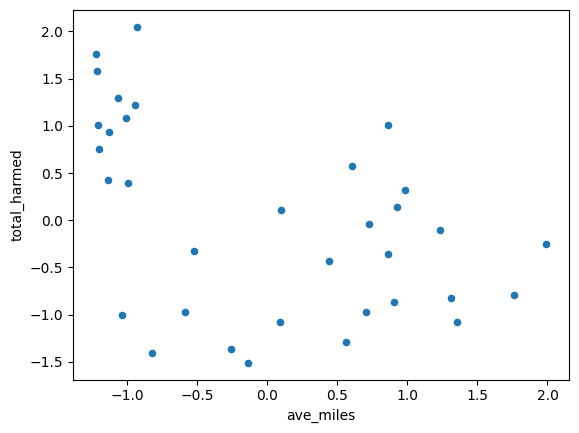

In [192]:
pd_transformed[['ave_miles', 'total_harmed']].plot.scatter(x='ave_miles', y='total_harmed')
plt.show()

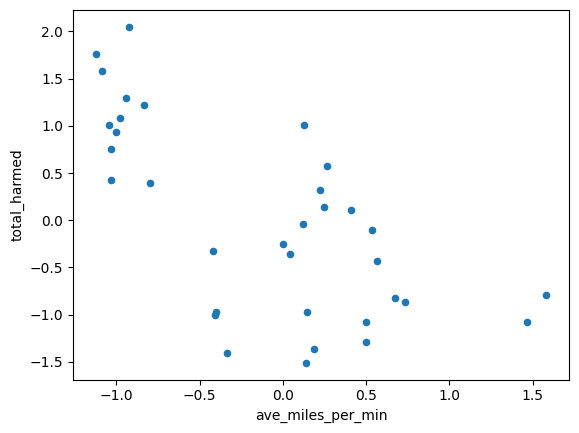

In [ ]:
pd_transformed[['ave_miles_per_min', 'total_harmed']].plot.scatter(x='ave_miles_per_min', y='total_harmed')
plt.show() 

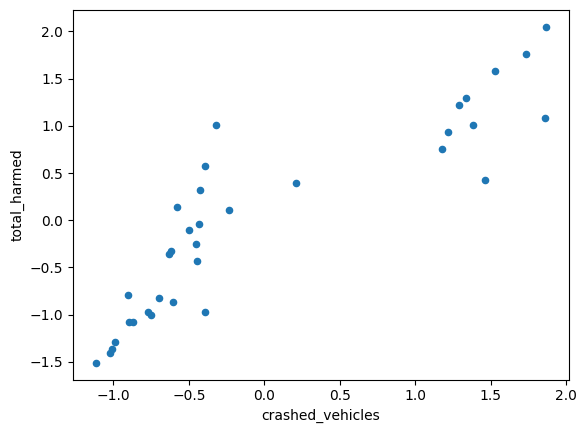

In [194]:
pd_transformed[['crashed_vehicles', 'total_harmed']].plot.scatter(x='crashed_vehicles', y='total_harmed')
plt.show()

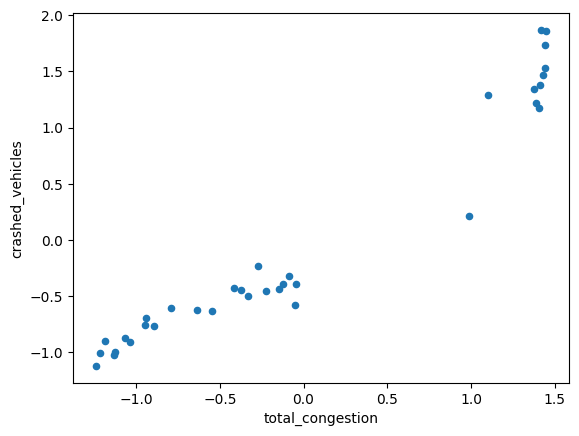

In [195]:
pd_transformed[['crashed_vehicles', 'total_congestion']].plot.scatter(x='total_congestion', y='crashed_vehicles')
plt.show()

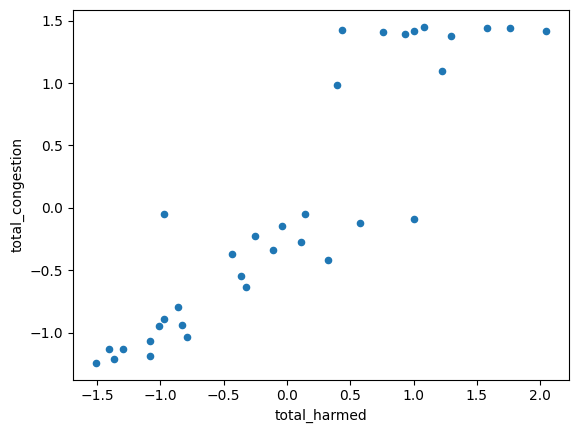

In [196]:
pd_transformed[['total_harmed', 'total_congestion']].plot.scatter(x='total_harmed', y='total_congestion')
plt.show()

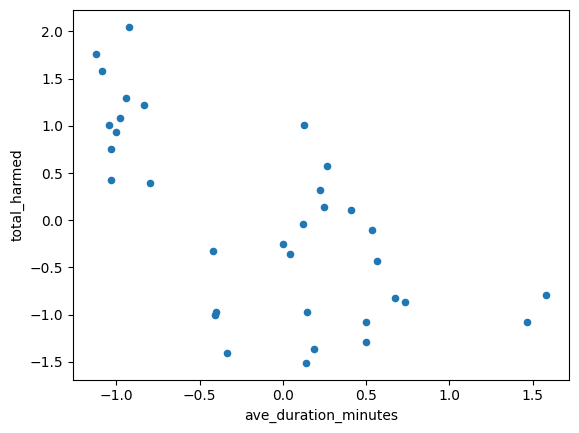

In [197]:
pd_transformed[['ave_duration_minutes', 'total_harmed']].plot.scatter(x='ave_duration_minutes', y='total_harmed')
plt.show()

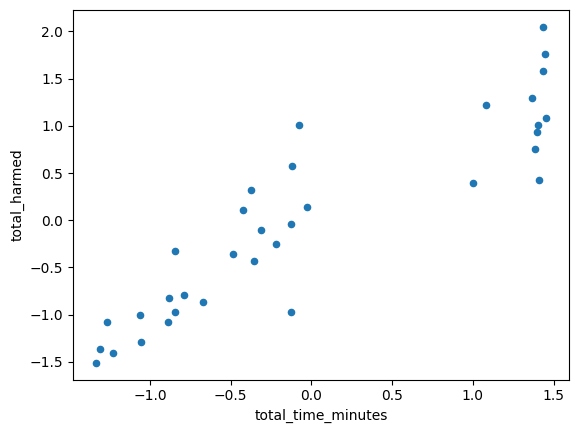

In [198]:
pd_transformed[['total_time_minutes', 'total_harmed']].plot.scatter(x='total_time_minutes', y='total_harmed')
plt.show()

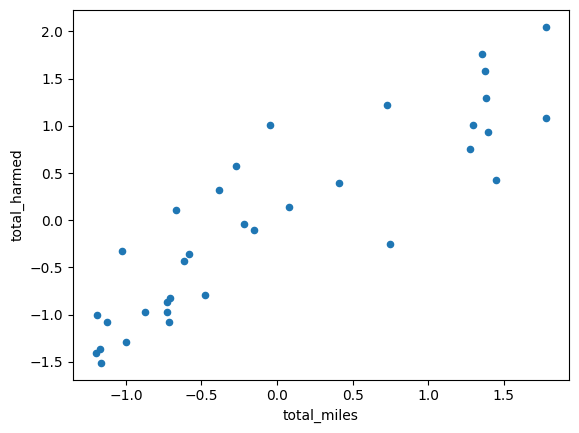

In [ ]:
pd_transformed[['total_miles', 'total_harmed']].plot.scatter(x='total_miles', y='total_harmed')
plt.show()

In [200]:
pd_transformed

,total_harmed,crashed_vehicles,total_miles,ave_duration_minutes,total_time_minutes,total_congestion,ave_miles_per_min,ave_miles,week
0,0.395582,0.211146,0.410359,-0.800251,1.000945,0.987761,-0.800251,-0.991446,1.0
1,0.935013,1.217954,1.395322,-1.000705,1.395332,1.389638,-1.000705,-1.129887,2.0
2,1.006937,1.382107,1.296452,-1.047804,1.406605,1.413933,-1.047804,-1.205901,3.0
3,0.755203,1.174180,1.273348,-1.034046,1.387908,1.405547,-1.034046,-1.198727,4.0
4,0.431544,1.464184,1.450855,-1.033856,1.407861,1.428390,-1.033856,-1.137339,5.0
5,1.582329,1.529845,1.372645,-1.088846,1.433885,1.439754,-1.088846,-1.212006,6.0
6,1.762139,1.732301,1.356816,-1.125536,1.449376,1.439368,-1.125536,-1.225147,7.0
7,1.294633,1.338333,1.380549,-0.943328,1.366683,1.376025,-0.943328,-1.065669,8.0
8,1.078861,1.858152,1.779689,-0.979116,1.456335,1.450682,-0.979116,-1.006756,9.0
9,2.049836,1.869096,1.781646,-0.923607,1.433079,1.419400,-0.923607,-0.932890,10.0


In [201]:
# Define predictors 
x_cols = ['crashed_vehicles', 'ave_miles',
       'ave_duration_minutes', 'ave_miles_per_min', 'total_miles',
       'total_time_minutes', 'total_congestion']
x = pd_transformed[x_cols]
x
y_cols = ['total_harmed']
y = pd_transformed['total_harmed']

Machine Learning Models

In [202]:
fit1 = ols(
    formula="total_harmed ~ crashed_vehicles + ave_miles + ave_duration_minutes + \
            ave_miles_per_min + total_miles + total_time_minutes + total_congestion",
    data=pd_transformed
).fit()

In [ ]:
print(fit1.summary()) # Full model

                            OLS Regression Results                            
Dep. Variable:           total_harmed   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     33.32
Date:                Sun, 25 Aug 2024   Prob (F-statistic):           2.93e-11
Time:                        21:00:10   Log-Likelihood:                -12.054
No. Observations:                  34   AIC:                             38.11
Df Residuals:                      27   BIC:                             48.79
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0016 

In [204]:
import numpy as np
from glmnet import ElasticNet


# LASSO Model
elastic_net_model = ElasticNet(alpha=1) 
elastic_net_model.fit(
    pd_transformed[x_cols].values, 
    pd_transformed[y_cols].values.flatten()
)

ElasticNet()

In [205]:
# Lambda Value
print(f'Best lambda value for LASSO: {elastic_net_model.lambda_best_[0]}')

Best lambda value for LASSO: 0.16937882896430154


In [206]:
pd.DataFrame(
    index=['Intercept'] + x_cols, 
    data=[elastic_net_model.intercept_] + list(elastic_net_model.coef_), 
    columns=['Coefficient']
) 

,Coefficient
Intercept,-3.397664e-17
crashed_vehicles,8.600636e-02
ave_miles,0.000000e+00
ave_duration_minutes,0.000000e+00
ave_miles_per_min,0.000000e+00
total_miles,1.103056e-01
total_time_minutes,3.268210e-01
total_congestion,2.197504e-01


In [207]:
from sklearn.model_selection import train_test_split
# Create train, test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [208]:
y_pred = elastic_net_model.predict(X_test)

# Import necessary libraries
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np
import matplotlib.pyplot as plt

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Print the model coefficients
print("Elastic Net Coefficients:")
print(elastic_net_model.coef_)
# Print the model intercept
print("Elastic Net Intercept:")
print(elastic_net_model.intercept_)
r2_score(y_test,y_pred)

Mean Squared Error: 0.1080706774996427
Elastic Net Coefficients:
[0.08600636 0.         0.         0.         0.11030558 0.32682105
 0.21975042]
Elastic Net Intercept:
-3.3976636866027226e-17


0.8180807249424848

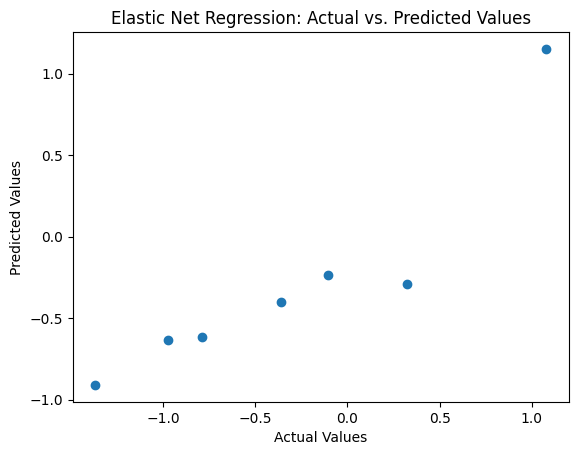

In [209]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Elastic Net Regression: Actual vs. Predicted Values")
plt.show()

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
train_sizes = [1, 27]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(), X = x,
y = y, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

In [212]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1 )
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1    -0.000000
27    0.113675
dtype: float64

 --------------------

Mean validation scores

 1     1.079995
27    0.200819
dtype: float64


(-0.5, 1.5)

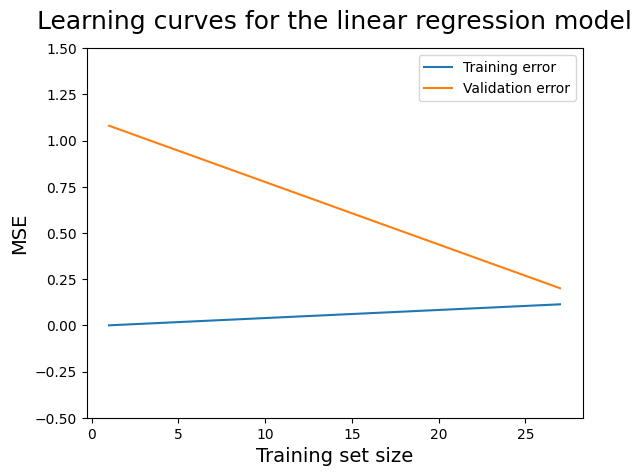

In [213]:
import matplotlib.pyplot as plt
import seaborn

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for the linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(-0.5,1.5)

In [ ]:
# estimate bias and variance
from mlxtend.evaluate import bias_variance_decomp
mse, bias, var = bias_variance_decomp(elastic_net_model, X_train.values, y_train.values, X_test.values, y_test.values, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.152
Bias: 0.097
Variance: 0.054


In [215]:
fit2 = ols(
    formula="total_harmed ~ crashed_vehicles + ave_miles \
          + total_time_minutes + total_congestion + total_miles", 

    data=pd_transformed
).fit() # AIC is lower when ave_duration_minutes and ave_miles_per_min are removed

print(fit2.summary())

                            OLS Regression Results                            
Dep. Variable:           total_harmed   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     41.46
Date:                Sun, 25 Aug 2024   Prob (F-statistic):           4.28e-12
Time:                        21:00:30   Log-Likelihood:                -12.055
No. Observations:                  34   AIC:                             36.11
Df Residuals:                      28   BIC:                             45.27
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -6.939e-18      0

Spark ML is unable to handle Null values, so these were previously imputed

In [ ]:
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler

features = 'features'
input_cols = ["crashed_vehicles", "ave_miles", "total_time_minutes", "total_congestion","total_miles"]

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

model_sdf = assembler.transform(sdf_transformed)
# Display the features and targets for our model
model_sdf.select('features').head(5), model_sdf.select('total_harmed').head(5)

([Row(features=DenseVector([0.2111, -0.9914, 1.0009, 0.9878, 0.4104])),
  Row(features=DenseVector([1.218, -1.1299, 1.3953, 1.3896, 1.3953])),
  Row(features=DenseVector([1.3821, -1.2059, 1.4066, 1.4139, 1.2965])),
  Row(features=DenseVector([1.1742, -1.1987, 1.3879, 1.4055, 1.2733])),
  Row(features=DenseVector([1.4642, -1.1373, 1.4079, 1.4284, 1.4509]))],
 [Row(total_harmed=0.39558229946312756),
  Row(total_harmed=0.9350127078219379),
  Row(total_harmed=1.0069367622697794),
  Row(total_harmed=0.7552025717023345),
  Row(total_harmed=0.4315443266870483)])

In [217]:
from pyspark.ml.regression import LinearRegression

lm = LinearRegression(
    featuresCol='features', 
    labelCol='total_harmed'
).fit(model_sdf)

24/08/25 21:00:30 WARN Instrumentation: [134fbff6] regParam is zero, which might cause numerical instability and overfitting.


In [218]:
# Access coefficients
pd.DataFrame(
    data=[lm.intercept] + list(lm.coefficients),
    index=['intercept'] + input_cols,
    columns=['coefficient']
)

,coefficient
intercept,2.803681e-15
crashed_vehicles,8.527275e-01
ave_miles,5.712214e-01
total_time_minutes,-1.969937e+00
total_congestion,2.880314e+00
total_miles,-4.846164e-01


In [219]:
# example record to predict
sdf_transformed.select('total_harmed', *input_cols).limit(1).show(vertical=True)

-RECORD 0---------------------------------
 total_harmed       | 0.39558229946312756 
 crashed_vehicles   | 0.2111463370830552  
 ave_miles          | -0.9914457204544836 
 total_time_minutes | 1.0009453600623976  
 total_congestion   | 0.9877605940821234  
 total_miles        | 0.41035926303324194 



In [220]:
# preprocess for predictions
predict_test = sdf_transformed.select(*input_cols).limit(1)

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

predict_sdf = assembler.transform(predict_test).select(features)

predict_sdf.show(1, vertical=True)

predictions = lm.transform(predict_sdf)
predictions.show(vertical=True, truncate=False)

# r2 example
lm.summary.r2

-RECORD 0------------------------
 features | [0.21114633708305... 

-RECORD 0--------------------------------------------------------------------------------------------------------
 features   | [0.2111463370830552,-0.9914457204544836,1.0009453600623976,0.9877605940821234,0.41035926303324194] 
 prediction | 0.28810961833531396                                                                                



0.881012337337856

Random Forest

In [221]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [222]:
from sklearn.ensemble import RandomForestRegressor
 
# Create a random forest regression model
model = RandomForestRegressor(n_estimators=100)
 
# Fit the model to the data
model.fit(x, y)
 
# Predict the response for a new data point
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

print("R2 Score:", r2)

# Make predictions

print("Prediction:", y_pred)

Mean Squared Error: 0.01046133239145794
Mean Absolute Error: 0.06971495848980065
R2 Score: 0.9823900613115336
Prediction: [-1.36583779 -0.72859067 -0.09062431  0.12910368  1.25255741 -0.32941217
 -0.96198423]


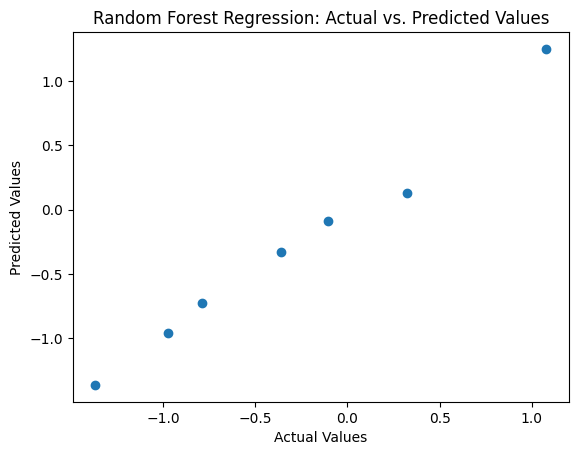

In [223]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression: Actual vs. Predicted Values")
plt.show() # Much better performance

Experimental Model: Not included in Report

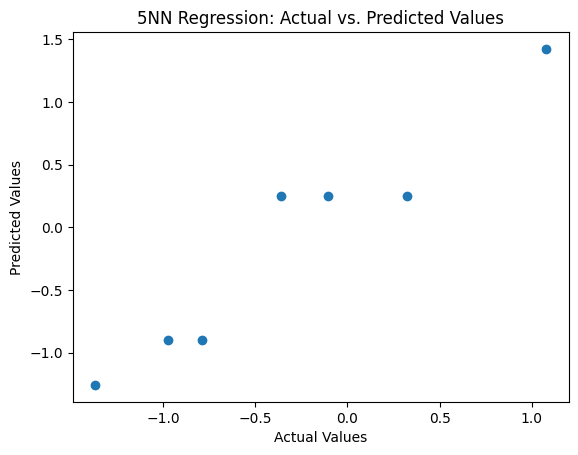

Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score for k=5: 0.8422729696108051
Score: 0.8422729696108051


In [224]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)
predictions = knn_regressor.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("5NN Regression: Actual vs. Predicted Values")
plt.show() # Much better performance
# Need to pick optimal K

for k in range(1, 10):
    knn_regressor = KNeighborsRegressor(n_neighbors=5)
    knn_regressor.fit(X_train, y_train)
    print(f'Score for k={5}: {knn_regressor.score(X_test, y_test)}')

# Evaluate the model
print('Score:', knn_regressor.score(X_test, y_test)) # The score() method gives us the coefficient of determination R^2 of the prediction


Support Vector Regression model

In [ ]:
from sklearn.svm import SVR
model = SVR(kernel='linear')
 
# Fiting the model
model.fit(x, y)
 
# Predictions for new data points
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

print("R2 Score:", r2)

# Make predictions
print("Prediction:", y_pred)

Mean Squared Error: 0.06848818717093577
Mean Absolute Error: 0.2011394012278637
R2 Score: 0.8847113606724522
Prediction: [-1.31908094 -0.8909233  -0.25003533 -0.21484462  1.36162024 -0.38009671
 -0.69412169]


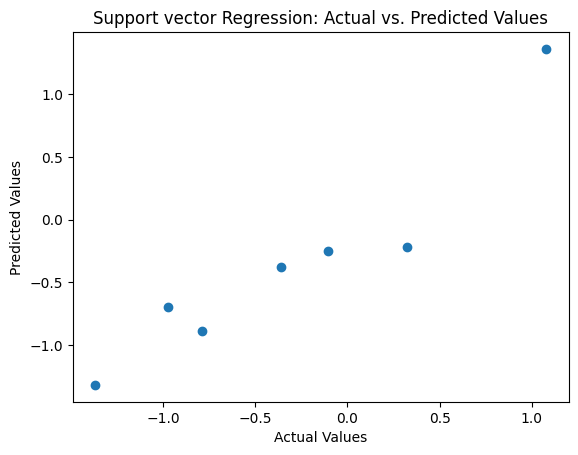

In [226]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Support vector Regression: Actual vs. Predicted Values")
plt.show()